<div style="background-color:yellow; text-align:center; text-align:center; padding:40px;">
<h1  style="color:red;" > DI-725 : Transformers and Attention-Based Deep Networks </h1>   
<h2  style="color:red;" > Assignment - 2 </h2>
<br>
<br>
<h4  style="color:red;" >Turgay Yıldız</h4>
<br>
<h4  style="color:red;" >Graduate School of Informatics,  Middle East Technical University (METU)</h4>
</div>


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  First Import the Relevant Packages  </h2>
</div>

In [176]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch import Tensor
import torchvision

from einops.layers.torch import Rearrange 

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np

from torch.optim import AdamW

import json

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tqdm
from PIL import Image

import wandb
import os
import cv2

from torch.amp import GradScaler, autocast


import requests
from torchvision.models import resnet50
import torchvision.transforms as T 

In [2]:
print(torch.cuda.is_available())

True


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  WANDB </h2>
</div>

In [4]:
print(os.getcwd())

/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_2


In [5]:
os.environ["WANDB_NOTEBOOK_NAME"] = "DI_725_Assignment_2__2697258.ipynb" 

In [6]:
#wandb.finish() 

In [7]:
run  =  wandb.init(project="DI_725_Assignment_2___2697258", entity="DI_725_Assignment_2___2697258") 

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: turgay-yildiz-phi-e-pi (DI_725___Final_Project) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Import Dataset  </h2>
</div>

In [8]:
path   =   "/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_2/"

In [9]:
images_p        =    os.listdir(path + "auair2019/images")
annotations_p   =   path + "auair2019/annotations.json"

In [10]:
images_p[:3]

['frame_20190905103112_xx_0000365.jpg',
 'frame_20190906150731_xx_0002188.jpg',
 'frame_20190906150731_x_0001674.jpg']

In [11]:
with open(annotations_p, 'r') as f:
    annotations = json.load(f)

In [12]:
annotations_info    =   annotations["info"]
annotations_ann     =   annotations["annotations"]

In [13]:
annotations_info

{'description': 'AUAIR 2019 Dataset',
 'url': 'https://bozcani.github.io/AU-AIR-dataset.html',
 'version': '1.0',
 'year': '2019',
 'contributor': 'Ilker Bozcan',
 'date_created': '2019/10/01'}

In [ ]:
len(annotations_ann)

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  BBoxes </h2>
</div>

In [177]:
annotations_ann[1]["bbox"]

[{'top': 857, 'left': 976, 'height': 86, 'width': 139, 'class': 0},
 {'top': 11, 'left': 624, 'height': 210, 'width': 328, 'class': 1}]

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Average Length of Detections for an image </h2>
</div>

In [178]:
summ = 0

for i in range(len(annotations_ann)):

    summ   +=    len(annotations_ann[i]["bbox"])

In [179]:
summ

132031

In [180]:
summ /  len(annotations_ann) 

4.0225147000578865

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Max Class Indices in an image</h2>
</div>

In [181]:
summs   =  [] 

for i in range(len(annotations_ann)):

    summs.append(len(annotations_ann[i]["bbox"]))

In [182]:
np.array(summs).max()

56

In [183]:
np.array(summs).argmax()

25251

In [184]:
annotations_ann[25251]["bbox"][:3]

[{'top': 396, 'left': 439, 'height': 35, 'width': 101, 'class': 1},
 {'top': 375, 'left': 453, 'height': 30, 'width': 105, 'class': 1},
 {'top': 347, 'left': 464, 'height': 31, 'width': 83, 'class': 1}]

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Unique Classes</h2>
</div>

In [185]:
lst   =   []

for i in range(len(annotations_ann)):

    bbox   =   annotations_ann[i]["bbox"]

    for j in range(len(bbox)):

        label   =   bbox[j]["class"] 

        if label  not  in  lst :
    
            lst.append(label) 


In [186]:
lst

[1, 0, 2, 3, 5, 7, 4, 6]

In [187]:
len(lst)

8

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Mapping Classes from AU-AIR to DETR </h2>
</div>

### This classes belong to DETR , we mapped our classes into it. 

In [13]:
CLASSES = [
    'van', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'bike',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'motorbike', 'backpack',
    'umbrella', 'trailer', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
] 

In [14]:
CLASSES.index("van")

0

In [15]:
CLASSES.index("person")

1

In [16]:
CLASSES.index("car")

3

In [17]:
CLASSES.index("truck")

8

In [18]:
CLASSES.index("bike")

12

In [19]:
CLASSES.index("motorbike")

26

In [20]:
CLASSES.index("bus")

6

In [21]:
CLASSES.index("trailer")

29

In [22]:
len(CLASSES)

91

In [24]:
clas_dic  =  { 0 : "person" , 1:"car", 2:"bus", 3:"van",  4:"truck",  5:"bike",  6:"motorbike",  7:"trailer"}

In [25]:
clas_dic[0]

'person'

In [26]:
CLASSES.index(clas_dic[0])

1

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Preprocess Data</h2>
</div>

In [27]:
def preprocess_annotations(annotations_ann, max_length=0):

    all_bboxes = []
    all_images = [] 


    path   =   "/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_2/auair2019/images/"

    for i in tqdm.tqdm(range(len(annotations_ann))):

        
        image_name    =     annotations_ann[i]["image_name"] 
        img_path      =     os.path.join(path ,  image_name)   


        all_images.append(img_path)


        
        len_bbox   =  len(annotations_ann[i]["bbox"]) 
        bbox_list  =  [    ] 

    
        
        for j in range(len_bbox):

            top     = annotations_ann[i]["bbox"][j]["top"]    / 1080.0
            left    = annotations_ann[i]["bbox"][j]["left"]   / 1920.0
            height  = annotations_ann[i]["bbox"][j]["height"] / 1080.0
            width   = annotations_ann[i]["bbox"][j]["width"]  / 1920.0
            clas    =   annotations_ann[i]["bbox"][j]["class"]

            one_hot    =  [0] * 92   
            
            index   =   CLASSES.index(clas_dic[clas]) 
            
            one_hot[index]    =   1  

            bbox_list.append([top, left, height, width] + one_hot ) 


        bbox_arr   =   np.array(bbox_list, dtype=np.float32) 


        if  len_bbox  <  max_length:

            pad          =   np.zeros((max_length - len_bbox,  96), dtype=np.int32)     #  4   +   91  +  1  
            pad[:, -1]   =   1  
            bbox_arr     =   np.concatenate([bbox_arr, pad], axis=0)

        elif len_bbox  >  max_length:

            bbox_arr             =   bbox_arr[:max_length] 

        
        all_bboxes.append(bbox_arr) 
    

    all_bboxes = np.stack(all_bboxes, axis=0) 
    all_images = np.stack(all_images, axis=0)


    return    all_images,    all_bboxes  


In [188]:
all_images,     all_bboxes    =    preprocess_annotations(annotations_ann, max_length=100) 

100%|██████████| 32823/32823 [00:01<00:00, 20750.10it/s]


In [189]:
all_images.shape,  all_bboxes.shape

((32823,), (32823, 100, 96))

In [190]:
all_bboxes[0,   :5,  :4] 

array([[0.15092592, 0.57187498, 0.1712963 , 0.21875   ],
       [0.38981482, 0.58749998, 0.16296296, 0.20468751],
       [0.85833335, 0.88697916, 0.14166667, 0.0953125 ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

In [191]:
all_bboxes[0,   :1,  4:] 

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Check the Preprocessed Data</h2>
</div>

In [192]:
all_images.shape

(32823,)

In [193]:
all_bboxes.shape

(32823, 100, 96)

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Original Dimensions : 1080 x 1920 </h2>
</div>

In [31]:
num   =  0

In [34]:
img   =   Image.open(all_images[num]).convert("RGB")

In [35]:
all_bboxes.shape

(32823, 60, 13)

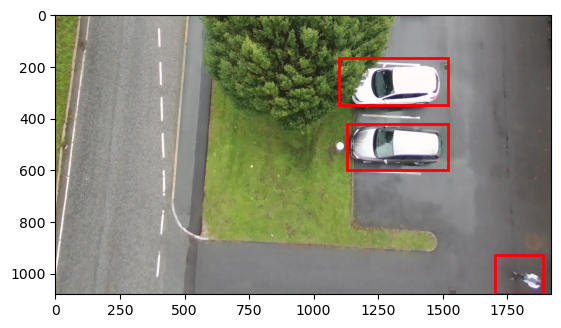

In [36]:
fig, ax = plt.subplots(1)


ax.imshow(img)

for i in range(60):
    
    rect = patches.Rectangle((all_bboxes[num][i][1]*1920, all_bboxes[num][i][0]*1080), all_bboxes[num][i][3]*1920, all_bboxes[num][i][2]*1080, linewidth=2, edgecolor='r', facecolor='none')
    
    ax.add_patch(rect)

plt.show()

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Split Dataset according to the Report Paper </h2>
</div>

```python
annotations_train_val        =    all_bboxes[:30000,    :,  :]
annotations_test             =    all_bboxes[30000:-1,  :,  :] 
```

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Prepare Dataset for Training </h2>
</div>

In [28]:
class AUAIRDataset(Dataset):

    def __init__(self,  test = False,  transform=None):

        
        self.transform          =   transform 
       

        all_images,     all_bboxes    =    preprocess_annotations(annotations_ann, max_length=100) 

        all_bboxes[:,  :,  0]   =  (all_bboxes[:,  :,  0] ) 
        all_bboxes[:,  :,  2]   =  (all_bboxes[:,  :,  2] ) 
        
        all_bboxes[:,  :,  1]   =  (all_bboxes[:,  :,  1] ) 
        all_bboxes[:,  :,  3]   =  (all_bboxes[:,  :,  3] )  

        
        if test:

            self.annotations    =   all_bboxes[30000:-1,  :,  :]  
            self.img_paths      =   all_images[30000:-1] 

        else:

            self.annotations    =   all_bboxes[:30000,    :,  :]
            self.img_paths      =   all_images[:30000]  

    
    def __len__(self):
        
        return    len(self.annotations)  


    def __getitem__(self, idx):

        data          =     self.annotations[idx]   
        img_path      =     self.img_paths[idx]  
            
        img           =     Image.open(img_path).convert("RGB")   


     
        if self.transform:
            
            x = self.transform(img) 

        else :

            x = img 

        
        x             =     np.array(x, dtype=np.float32) / 255.0  
        x             =     x = torch.tensor(x).view(3, 800, 800)  
        
        return     x,       torch.tensor(data[..., :4]).float()    ,   torch.tensor(data[..., 4:]).float() 



In [29]:
data_transform = transforms.Compose([
    
    transforms.Resize((800,800)), 
])


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  For Training   </h2>
</div>

In [36]:
dataset      =   AUAIRDataset(    test=False,    transform  =  data_transform)  

100%|██████████| 32823/32823 [00:02<00:00, 15353.01it/s]


In [37]:
len(dataset)

100

In [38]:
train_size   =    int(0.9 * len(dataset))
val_size     =    len(dataset) - train_size 

In [39]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size]) 

In [40]:
train_loader   =   DataLoader(train_dataset, batch_size=4, num_workers  =   8,   pin_memory = True,    shuffle=True)
val_loader     =   DataLoader(val_dataset,   batch_size=4, num_workers  =   8,   pin_memory = True,    shuffle=True) 

In [41]:
for a, b, c in train_loader:
    break 

In [42]:
a.shape

torch.Size([4, 3, 800, 800])

In [43]:
b.shape

torch.Size([4, 100, 4])

In [44]:
c.shape

torch.Size([4, 100, 92])

In [45]:
a.max(), b.max(), c.max()

(tensor(1.), tensor(0.7786), tensor(1.))

In [46]:
b[0, :5]

tensor([[0.6426, 0.5958, 0.0407, 0.0286],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]])

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  For Testing (Unseen Data)   </h2>
</div>

In [ ]:
#dataset2       =   AUAIRDataset(all_images,  all_bboxes,      test=True,    transform  =  data_transform)

In [ ]:
#len(dataset2)

In [ ]:
#test_loader   =   DataLoader(dataset2,  batch_size=16, num_workers  =   8,   pin_memory = True,   shuffle=True)

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Dimensions of Scaled-Data  </h2>
</div>

In [50]:
a.shape

torch.Size([4, 3, 800, 800])

In [51]:
b.shape

torch.Size([4, 100, 4])

In [52]:
bbox  =    b

In [53]:
height   =  800
width    =  800 

In [54]:
bbox[:,  :,  0]   =  (bbox[:,  :,  0] * height).int()
bbox[:,  :,  2]   =  (bbox[:,  :,  2] * height).int() 

bbox[:,  :,  1]   =  (bbox[:,  :,  1] * width).int() 
bbox[:,  :,  3]   =  (bbox[:,  :,  3] * width).int()  

In [55]:
bbox.shape

torch.Size([4, 100, 4])

In [56]:
bbox[0, :5, :]

tensor([[514., 476.,  32.,  22.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.]])

In [57]:
num  =  1

### [ymin, xmin, height, width] 

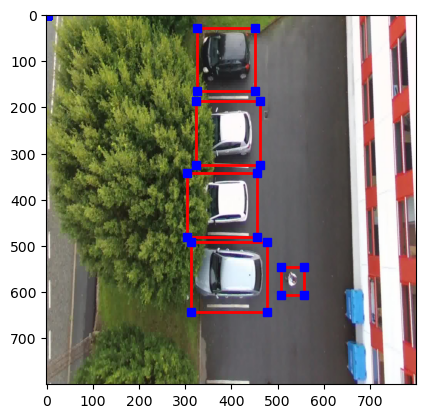

In [59]:
fig, ax = plt.subplots(1)


ax.imshow(a[num].reshape(800, 800, 3))


ax.plot(bbox[num,  :,  1] ,  bbox[num,  :,  0], "bs")                                     #   1,       0   
ax.plot(bbox[num,  :,  1] ,  bbox[num,  :,  0] + bbox[num,  :,  2],   "bs")                 #   1,       0+2
ax.plot(bbox[num,  :,  1] + bbox[num,  :,  3],   bbox[num,  :,  0], "bs")                #   1+3      0
ax.plot(bbox[num,  :,  1] + bbox[num,  :,  3],   bbox[num,  :,  0] + bbox[num,  :,  2], "bs")  #   1+3      0+2 



for k in range(100):
    
    rect = patches.Rectangle((bbox[num][k][1] , bbox[num][k][0]), bbox[num][k][3], bbox[num][k][2], linewidth=2, edgecolor='r', facecolor='none')
    
    ax.add_patch(rect)


plt.show()

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Convert Data Type :  </h2>
</div>

In [62]:
def box_yminxminhw_to_center(boxes):
    ymin, xmin, h, w = boxes.unbind(-1)
    cx = xmin + w / 2
    cy = ymin + h / 2
    return torch.stack((cx, cy, w, h), dim=-1)


In [63]:
bbox.min(),  bbox.max()

(tensor(0.), tensor(622.))

In [64]:
bbox_c   =   box_yminxminhw_to_center(bbox)

In [65]:
bbox_c.min(), bbox_c.max()

(tensor(0.), tensor(661.5000))

### We can plot centers : 

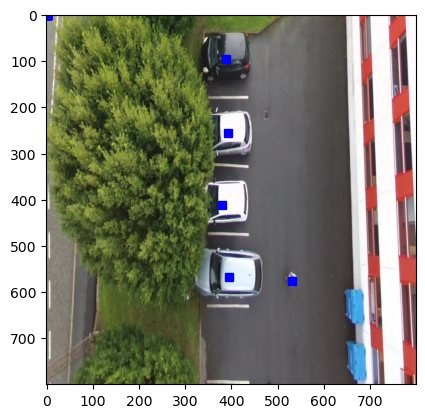

In [66]:
fig, ax = plt.subplots(1)


ax.imshow(a[num].reshape(height, width, 3))


ax.plot(bbox_c[num,  :,  0] ,  bbox_c[num,  :,  1], "bs")                     





plt.show()

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Re-Convert Data Type to Original:  </h2>
</div>

In [67]:
def box_center_to_yminxminhw(boxes):
    cx, cy, w, h = boxes.unbind(-1)
    ymin = cy - h / 2
    xmin = cx - w / 2
    return torch.stack((ymin, xmin, h, w), dim=-1)


In [68]:
bbox_xmin  =   box_center_to_yminxminhw(bbox_c)

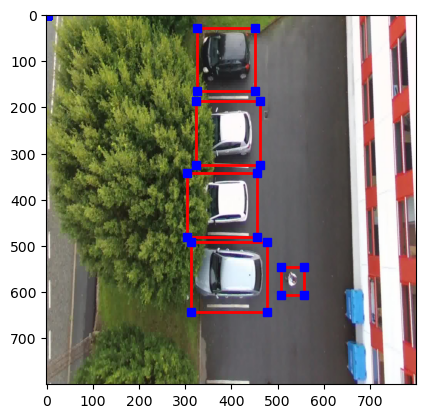

In [70]:
fig, ax = plt.subplots(1)


ax.imshow(a[num].reshape(height, width, 3))


ax.plot(bbox_xmin[num,  :,  1] ,  bbox_xmin[num,  :,  0], "bs")                                     #   1,       0   
ax.plot(bbox_xmin[num,  :,  1] ,  bbox_xmin[num,  :,  0] + bbox_xmin[num,  :,  2],   "bs")                 #   1,       0+2
ax.plot(bbox_xmin[num,  :,  1] + bbox_xmin[num,  :,  3],   bbox_xmin[num,  :,  0], "bs")                #   1+3      0
ax.plot(bbox_xmin[num,  :,  1] + bbox_xmin[num,  :,  3],   bbox_xmin[num,  :,  0] + bbox_xmin[num,  :,  2], "bs")  #   1+3      0+2 



for k in range(100):
    
    rect = patches.Rectangle((bbox_xmin[num][k][1] , bbox_xmin[num][k][0]), bbox_xmin[num][k][3], bbox_xmin[num][k][2], linewidth=2, edgecolor='r', facecolor='none')
    
    ax.add_patch(rect)


plt.show()

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:10px;">
<h2>  Model </h2>
</div>


In [30]:
class DETR(nn.Module):

    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc


        self.conv = nn.Conv2d(2048, hidden_dim, 1)

#----------------------------------------------------------------------------------------#
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)
#----------------------------------------------------------------------------------------#

        self.linear_class   =   nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox    =   nn.Linear(hidden_dim, 4)

#----------------------------------------------------------------------------------------#
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))
#----------------------------------------------------------------------------------------#
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
#----------------------------------------------------------------------------------------#
    def forward(self, inputs):
    
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
    
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        
#----------------------------------------------------------------------------------------#
        h = self.conv(x)

#----------------------------------------------------------------------------------------#
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

#----------------------------------------------------------------------------------------#    
        batch_size = inputs.size(0)
    
#----------------------------------------------------------------------------------------#
        query_pos = self.query_pos.unsqueeze(0).repeat(batch_size, 1, 1)  # [batch_size, num_queries, D]
        query_pos = query_pos.permute(1, 0, 2)                            # [num_queries, batch_size, D]
        
#----------------------------------------------------------------------------------------#
        src = pos + 0.1 * h.flatten(2).permute(2, 0, 1)                   # [HW, batch_size, D]
        
#----------------------------------------------------------------------------------------#
        h = self.transformer(src, query_pos).transpose(0, 1)              # [batch_size, num_queries, D]

#----------------------------------------------------------------------------------------#
        return {
        'pred_logits': self.linear_class(h),
        'pred_boxes': self.linear_bbox(h).sigmoid()
        }  




<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Clear CUDA :</h2>
</div>

In [31]:
import gc

In [32]:
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) and obj.is_cuda:
            del obj
            
    except:
        pass
            

/home/turgay/anaconda3/envs/DI_725_assignment_2/lib/python3.8/site-packages/torch/__init__.py:836: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)


In [33]:

def clear_cuda(verbose=False):

    import gc
    # List of big variables to explicitly delete (add as needed)
    big_vars = ['model', 'train_loader', 'val_loader', 'optimizer',
                'scheduler', "checkpoint_weights", "state_dict"
               ]

    for var in big_vars:
        if var in globals():
            del globals()[var]

    gc.collect()
    torch.cuda.empty_cache()

    if verbose:
        print(torch.cuda.memory_summary())



<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Loaders :</h2>
</div>

In [34]:
def loaders(batch_size=0, num_workers =0, shuffle=True, transform=None,  test=False, pin_memory=False):

    dataset      =   AUAIRDataset(    test=test,    transform  =  transform)
    train_size   =    int(0.9 * len(dataset))
    val_size     =    len(dataset) - train_size 

    
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size]) 

    train_loader   =   DataLoader(train_dataset, batch_size=batch_size, num_workers  =   num_workers,   pin_memory = pin_memory,    shuffle=shuffle)
    val_loader     =   DataLoader(val_dataset,   batch_size=batch_size, num_workers  =   num_workers,   pin_memory = pin_memory,    shuffle=shuffle) 

    return     train_loader,     val_loader       



<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Check Number of  Parameters :</h2>
</div>

In [35]:
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [36]:
clear_cuda()

In [37]:
train_loader,   val_loader   =   loaders(batch_size = 4, num_workers = 8, shuffle=True, transform=data_transform) 

100%|██████████| 32823/32823 [00:01<00:00, 18385.60it/s]


In [38]:
len(train_loader)

6750

In [39]:
#train_loader   =   DataLoader(train_dataset, batch_size=8, num_workers  =   8,   pin_memory = True,    shuffle=True)
#val_loader     =   DataLoader(val_dataset,   batch_size=8, num_workers  =   8,   pin_memory = True,    shuffle=True)   

In [40]:
model   =   DETR(91)

/home/turgay/anaconda3/envs/DI_725_assignment_2/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [41]:
for name, param in model.backbone.named_parameters():
    if "layer4" in name:
        param.requires_grad = False 
    else:
        param.requires_grad = False 


In [42]:
#for name, param in model.backbone.named_parameters():
    #if param.requires_grad:
        #print(name)

In [43]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of trainable parameters in the model:", num_params)

Number of trainable parameters in the model: 17951584


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Employ GPU</h2>
</div>

In [44]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [45]:
device

device(type='cuda')

In [46]:
#model      =        model.to(device)   

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  To Save Weights and Losses : </h2>
</div>

In [47]:
path_model   =  "/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_2/weights/Transformer_weight_1.pth"
path_losses  =  "/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_2/weights/Transformer_losses_1.pth"  

In [48]:
if 1:

    state_dict = torch.hub.load_state_dict_from_url(
                                                    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
                                                    map_location='cuda', check_hash=True)

    #for k in list(state_dict.keys()):
     #   if k.startswith('linear_class'):
      #      del state_dict[k] 

    
    torch.save({
            'model_state_dict': state_dict,
            'best_loss'       : 9999999999999,
        }, path_model)   

In [49]:
if 1:
    
    torch.save({
        
            'train_loss'    : [],
            'val_loss'      : [], 
    
            'epochs'        : [],
    
        }, path_losses)    

In [50]:
if 1:
    
    checkpoint_weights   =   torch.load(path_model,  weights_only=True) 
    checkpoint_losses    =   torch.load(path_losses, weights_only=True)  
    
    model.load_state_dict(checkpoint_weights['model_state_dict']) 
    
    best_loss       =  checkpoint_weights['best_loss'] 
    train_loss      =  checkpoint_losses['train_loss']
    val_loss        =  checkpoint_losses['val_loss']
    
    epochs          =  checkpoint_losses['epochs'] 

In [51]:
model      =        model.to(device)   

In [52]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of trainable parameters in the model:", num_params)

Number of trainable parameters in the model: 17951584


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Training : </h2>
</div>

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:0px;">
<h2>  Hungarian Matcher </h2>
</div>

In [53]:
from scipy.optimize import linear_sum_assignment

In [54]:
class HungarianMatcher:
    def __init__(self, cost_class=1.0, cost_bbox=1.0):
        self.cost_class = cost_class
        self.cost_bbox  = cost_bbox

    @torch.no_grad()
    def forward(self, outputs, targets):
        """
        Args:
            outputs: dict containing 'pred_logits' and 'pred_boxes'
                     - pred_logits: [batch_size, num_queries, num_classes]
                     - pred_boxes:  [batch_size, num_queries, 4]
            targets: list of dicts, each with:
                     - 'labels': [num_target_boxes] 
                     - 'boxes':  [num_target_boxes, 4]
        Returns:
            list of (index_pred, index_target) for each batch element
        """
        bs, num_queries = outputs['pred_logits'].shape[:2]

        # Flatten predictions
        out_prob = outputs['pred_logits'].softmax(-1)  # [bs, num_queries, num_classes]
        out_bbox = outputs['pred_boxes']               # [bs, num_queries, 4]

        indices = []

        for b in range(bs):
            tgt_labels = targets[b]['labels']           # [num_target_boxes]
            tgt_bbox   = targets[b]['boxes']            # [num_target_boxes, 4]

            # Compute classification cost
            cost_class = -out_prob[b][:, tgt_labels]    # [num_queries, num_target_boxes]

            # Compute bbox L1 cost
            cost_bbox = torch.cdist(out_bbox[b], tgt_bbox, p=1)  # [num_queries, num_target_boxes]

            # Final cost matrix
            C = self.cost_class * cost_class + self.cost_bbox * cost_bbox
            C = C.cpu()

            # Hungarian matching
            indices_batch = linear_sum_assignment(C)
            indices.append(indices_batch)

        return indices

In [55]:
matcher = HungarianMatcher(cost_class=1.0, cost_bbox=5.0)

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Data Type Conversions : </h2>
</div>

In [56]:
def box_yminxminhw_to_center(boxes):
    ymin, xmin, h, w = boxes.unbind(-1)
    cx = xmin + w / 2
    cy = ymin + h / 2
    return torch.stack((cx, cy, w, h), dim=-1)


def box_center_to_yminxminhw(boxes):
    cx, cy, w, h = boxes.unbind(-1)
    ymin = cy - h / 2
    xmin = cx - w / 2
    return torch.stack((ymin, xmin, h, w), dim=-1)


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Train & Validation Function : </h2>
</div>

In [57]:
def train(
    num_epochs: int = 0,
    patience: int = 0,
    best_loss: float = float('inf'),
    counter: int = 0,
):
    """
    Training loop with combined bbox and classification loss.
    """
    train_loss_t, val_loss_t, epochs_t = [], [], []

    for epoch in range(1, num_epochs + 1):
        
        model.train()
        
        total_train_loss = 0.0
        total_bbox_loss  = 0.0
        total_clas_loss  = 0.0

        for img, bbox, clas in tqdm.tqdm(train_loader, desc=f"Training Epoch {epoch}/{num_epochs}"):
            img, bbox, clas = img.to(device), bbox.to(device), clas.to(device)
            optimizer.zero_grad()

            # forward pass

            outputs = model(img)
            pred_boxes = outputs['pred_boxes']    # [bs, num_queries, 4]
            pred_logits = outputs['pred_logits']  # [bs, num_queries, num_classes]
            
            # Prepare targets for matcher
            targets_list = []
            for b in range(img.size(0)):
                targets_list.append({
                    'labels': clas[b].argmax(dim=1),   # assuming one-hot or multi-label one-hot
                    'boxes': bbox[b]
                })
            
            # Get matching indices
            matches = matcher.forward(outputs, targets_list)
            
            # Compute losses for each sample in batch
            bbox_loss_total = 0.0
            clas_loss_total = 0.0
            
            for b in range(img.size(0)):
                idx_pred, idx_tgt = matches[b]
            
                if len(idx_pred) == 0:
                    continue  # no match for this image
            
                matched_pred_boxes  = pred_boxes[b][idx_pred]
                matched_target_boxes= bbox[b][idx_tgt]
            
                matched_pred_logits = pred_logits[b][idx_pred]
                matched_target_labels= clas[b][idx_tgt]
            
                bbox_loss = F.l1_loss(matched_pred_boxes, matched_target_boxes)
                clas_loss = criterion_bce(matched_pred_logits, matched_target_labels)
            
                bbox_loss_total += bbox_loss
                clas_loss_total += clas_loss
            
            # Average over batch
            bbox_loss_total /= img.size(0)
            clas_loss_total /= img.size(0)
            loss = bbox_loss_total + clas_loss_total


            # backward + optimize
            loss.backward()
            optimizer.step()
 

            # accumulate
            total_train_loss += loss.item()
            total_bbox_loss  += bbox_loss.item()
            total_clas_loss  += clas_loss.item()

        # compute averages
        avg_train_loss = total_train_loss / len(train_loader)
        avg_bbox_loss  = total_bbox_loss  / len(train_loader)
        avg_clas_loss  = total_clas_loss  / len(train_loader)
        train_loss.append(avg_train_loss)

        # log
        run.log({
            "Train Loss": avg_train_loss,
            "Train BBox": avg_bbox_loss,
            "Train Cls": avg_clas_loss
        })

        print(
            f"Epoch {epoch}/{num_epochs} | "
            f"Train Loss: {avg_train_loss:.4f} | "
            f"BBox Loss: {avg_bbox_loss:.4f} | "
            f"Cls Loss: {avg_clas_loss:.4f}"
        )

        # validation
        model.eval()
        total_val_loss = 0.0
        total_val_bbox = 0.0
        total_val_clas = 0.0

        with torch.no_grad():
            for img, bbox, clas in tqdm.tqdm(val_loader, desc=f"Validating Epoch {epoch}/{num_epochs}"):
                img, bbox, clas = img.to(device), bbox.to(device), clas.to(device)
                

                outputs = model(img)
                pred_boxes = outputs['pred_boxes']    # [bs, num_queries, 4]
                pred_logits = outputs['pred_logits']  # [bs, num_queries, num_classes]
                    
            
                # Prepare targets for matcher
                targets_list = []
            
                for b in range(img.size(0)):
                    targets_list.append({
                        'labels': clas[b].argmax(dim=1),   # assuming one-hot or multi-label one-hot
                        'boxes': bbox[b]
                    })
                
                # Get matching indices
                matches = matcher.forward(outputs, targets_list)
                
                # Compute losses for each sample in batch
                bbox_loss_total = 0.0
                clas_loss_total = 0.0
                
                for b in range(img.size(0)):
                    idx_pred, idx_tgt = matches[b]
                
                    if len(idx_pred) == 0:
                        continue  # no match for this image
                
                    matched_pred_boxes  = pred_boxes[b][idx_pred]
                    matched_target_boxes= bbox[b][idx_tgt]
                
                    matched_pred_logits = pred_logits[b][idx_pred]
                    matched_target_labels= clas[b][idx_tgt]
                
                    bbox_loss = F.l1_loss(matched_pred_boxes, matched_target_boxes)
                    clas_loss = criterion_bce(matched_pred_logits, matched_target_labels)
                
                    bbox_loss_total += bbox_loss
                    clas_loss_total += clas_loss
                
                # Average over batch
                bbox_loss_total /= img.size(0)
                clas_loss_total /= img.size(0)
                loss = bbox_loss_total + clas_loss_total


                total_val_loss += loss.item()
                total_val_bbox += bbox_loss.item()
                total_val_clas += clas_loss.item()

        # compute averages
        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_bbox = total_val_bbox / len(val_loader)
        avg_val_clas = total_val_clas / len(val_loader)
        val_loss.append(avg_val_loss)

        # log
        run.log({
            "Val Loss": avg_val_loss,
            "Val BBox": avg_val_bbox,
            "Val Cls": avg_val_clas
        })

        print(
            f"Epoch {epoch}/{num_epochs} | "
            f"Val Loss: {avg_val_loss:.4f} | "
            f"BBox Loss: {avg_val_bbox:.4f} | "
            f"Cls Loss: {avg_val_clas:.4f}"
        )

        # early stopping & save best
        if avg_val_loss < best_loss:
            print("Saving new best model...")
            best_loss = avg_val_loss
            torch.save({'model_state_dict': model.state_dict(), 'best_loss': best_loss}, path_model)
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered!")
                break

        epochs.append(epoch)
        torch.save({'train_loss': train_loss_t, 'val_loss': val_loss_t, 'epochs': epochs_t}, path_losses)
        scheduler.step()
        torch.cuda.empty_cache()


In [58]:
learning_rate   =  0.0001

In [59]:
optimizer       =   AdamW(model.parameters(), lr=learning_rate)
criterion_bce   =   nn.BCEWithLogitsLoss()
criterion_l1    =   nn.L1Loss()

run.log({"LRate": learning_rate})  

scheduler       =   torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.8)

In [60]:
train(num_epochs=10, patience=10, counter=0, best_loss=best_loss)  

Training Epoch 1/10: 100%|██████████| 6750/6750 [33:44<00:00,  3.33it/s]


Epoch 1/10 | Train Loss: 0.0108 | BBox Loss: 0.0086 | Cls Loss: 0.0022


Validating Epoch 1/10: 100%|██████████| 750/750 [02:24<00:00,  5.20it/s]


Epoch 1/10 | Val Loss: 0.0108 | BBox Loss: 0.0073 | Cls Loss: 0.0036
Saving new best model...


Training Epoch 2/10: 100%|██████████| 6750/6750 [33:43<00:00,  3.34it/s]


Epoch 2/10 | Train Loss: 0.0091 | BBox Loss: 0.0072 | Cls Loss: 0.0020


Validating Epoch 2/10: 100%|██████████| 750/750 [02:24<00:00,  5.19it/s]


Epoch 2/10 | Val Loss: 0.0145 | BBox Loss: 0.0100 | Cls Loss: 0.0046


Training Epoch 3/10: 100%|██████████| 6750/6750 [33:46<00:00,  3.33it/s]


Epoch 3/10 | Train Loss: 0.0090 | BBox Loss: 0.0070 | Cls Loss: 0.0019


Validating Epoch 3/10: 100%|██████████| 750/750 [02:24<00:00,  5.18it/s]


Epoch 3/10 | Val Loss: 0.0142 | BBox Loss: 0.0094 | Cls Loss: 0.0051


Training Epoch 4/10:  20%|██        | 1358/6750 [06:49<27:07,  3.31it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/turgay/anaconda3/envs/DI_725_assignment_2/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
Traceback (most recent call last):
Training Epoch 4/10:  20%|██        | 1358/6750 [06:49<27:05,  3.32it/s]  File "/home/turgay/anaconda3/envs/DI_725_assignment_2/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/turgay/anaconda3/envs/DI_725_assignment_2/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/turgay/anaconda3/envs/DI_725_assignment_2/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/turgay/anacond

KeyboardInterrupt: 

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Plot Losses : </h2>
</div>

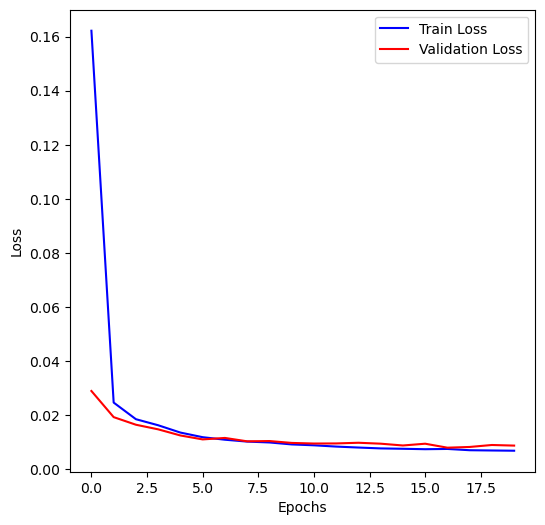

In [106]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.plot(train_loss, "b-", label="Train Loss")
ax.plot(val_loss, "r-", label="Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

#ax.set_xlim([0, 10])
#ax.set_ylim([0,1])

ax.legend()

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Results : </h2>
</div>

In [61]:
e  =  model.eval()

In [82]:
for imgs, bbox, clas in train_loader:
    break

In [63]:
imgs.shape

torch.Size([4, 3, 800, 800])

In [64]:
bbox.shape

torch.Size([4, 100, 4])

In [65]:
def box_center_to_yminxminhw(boxes):
    cx, cy, w, h = boxes.unbind(-1)
    ymin = cy - h / 2
    xmin = cx - w / 2
    return torch.stack((ymin, xmin, h, w), dim=-1)


In [66]:
with torch.no_grad():

    img            =     (imgs).to(device) 

    out            =     model(img)       
    


In [67]:
p_cls          =        out["pred_logits"]
p_box_c        =        out["pred_boxes"] 

In [68]:
p_box_c[0, :5, :]

tensor([[1.3962e-04, 2.7751e-04, 2.2346e-05, 8.2068e-06],
        [1.3968e-04, 2.7764e-04, 2.2353e-05, 8.2100e-06],
        [1.3961e-04, 2.7749e-04, 2.2344e-05, 8.2063e-06],
        [1.3966e-04, 2.7760e-04, 2.2351e-05, 8.2090e-06],
        [1.3967e-04, 2.7763e-04, 2.2353e-05, 8.2097e-06]], device='cuda:0')

In [69]:
p_box          =        box_center_to_yminxminhw(p_box_c)    

In [70]:
p_box[0, :3, :]

tensor([[2.7341e-04, 1.2845e-04, 8.2068e-06, 2.2346e-05],
        [2.7354e-04, 1.2850e-04, 8.2100e-06, 2.2353e-05],
        [2.7339e-04, 1.2844e-04, 8.2063e-06, 2.2344e-05]], device='cuda:0')

In [75]:
num  =  1

In [76]:
#p_box = p_box_c

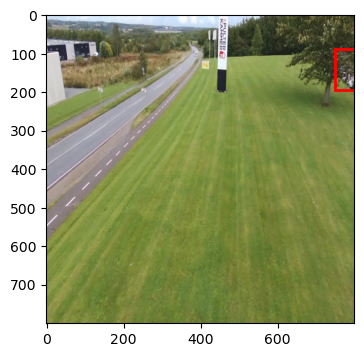

In [77]:
fig, ax = plt.subplots(1, figsize=(12,4))

width   =  800
height  =  800 

ax.imshow(imgs[num].view(height, width, 3)) 

for k in range(100):
    
    rect = patches.Rectangle( (bbox[num][k][1]*width, bbox[num][k][0]*height), bbox[num][k][3]*width, bbox[num][k][2]*height, linewidth=2, edgecolor='r', facecolor='none')
    
    ax.add_patch(rect)


for k in range(100): 
    
    rect = patches.Rectangle( ((p_box[0][k][1]*width).cpu(), (p_box[0][k][0]*height).cpu() ), (p_box[0][k][3]*width).cpu(), (p_box[0][k][2]*height).cpu(), linewidth=2, edgecolor='b', facecolor='none')
    
    ax.add_patch(rect)

plt.show()

In [78]:
p_box[0, 0]

tensor([2.7341e-04, 1.2845e-04, 8.2068e-06, 2.2346e-05], device='cuda:0')

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Evaluation Metrices</h2>
</div>

In [79]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [171]:
metric = MeanAveragePrecision(iou_type="bbox")
metric.reset()

model.eval()

preds   = []
targets = []

with torch.no_grad():
    for imgs, gt_boxes, gt_labels in tqdm.tqdm(val_loader, desc="Evaluating mAP"):
        imgs = imgs.to(device)
        out = model(imgs)

        probs  = F.softmax(out['pred_logits'], dim=-1)
        scores, labels = probs.max(-1)           # [B, Q]
        preds_boxes = out['pred_boxes']          # [B, Q, 4] in [0,1]

        B, Q, _ = preds_boxes.shape
        H, W  = imgs.shape[-2:]
        scale = torch.tensor([W, H, W, H], device=imgs.device)
        boxes = preds_boxes * scale

        for b in range(B):
            keep = scores[b] > 0.5

            preds.append({
                "boxes":  boxes[b][keep].cpu(),
                "scores": scores[b][keep].cpu(),
                "labels": labels[b][keep].cpu().to(torch.int64)
            })

            # Ground truth: filter out zero-area boxes
            tgb = gt_boxes[b].to(imgs.device)
            widths  = tgb[:, 2] - tgb[:, 0]
            heights = tgb[:, 3] - tgb[:, 1]
            valid   = (widths > 0) & (heights > 0)
            tgb     = tgb[valid]

            # Handle labels — convert one-hot/multi-hot to scalar class indices if needed
            raw_tgl = gt_labels[b].to(imgs.device)
            raw_tgl = raw_tgl[valid]

            if raw_tgl.ndim > 1:
                tgl = raw_tgl.argmax(dim=-1)
            else:
                tgl = raw_tgl

            targets.append({
                "boxes":  tgb.cpu(),
                "labels": tgl.cpu().to(torch.int64)
            })


Evaluating mAP: 100%|██████████| 750/750 [02:24<00:00,  5.20it/s]


In [172]:
metric.update(preds=preds, target=targets) 

In [173]:
results   =   metric.compute() 

In [174]:
print(results)

{'map': tensor(0.), 'map_50': tensor(0.), 'map_75': tensor(0.), 'map_small': tensor(0.), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.), 'mar_10': tensor(0.), 'mar_100': tensor(0.), 'mar_small': tensor(0.), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 0,  3,  6, 12, 26, 29, 91], dtype=torch.int32)}


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Sync for WANDB</h2>
</div>

In [194]:
run.finish() 

LRate,▁
Train BBox,█▂▁
Train Cls,█▂▁
Train Loss,█▁▁
Val BBox,▁█▇
Val Cls,▁▆█
Val Loss,▁█▇
LRate,0.0001
Train BBox,0.00702
Train Cls,0.0019
Train Loss,0.00901
